In [1]:
!pip install onnx
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 72.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.7 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torchvision import transforms

from PIL import Image
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### Sử dụng pre-trained từ thư viện torchvision

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 282MB/s]


In [4]:
coco_names = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus',
              'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
              'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
              'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
              'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
              'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
              'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 
              'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 
              'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 
              'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
              'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
              'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
model = model.to(device)

In [8]:
transform = transforms.ToTensor()

## Prediction

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


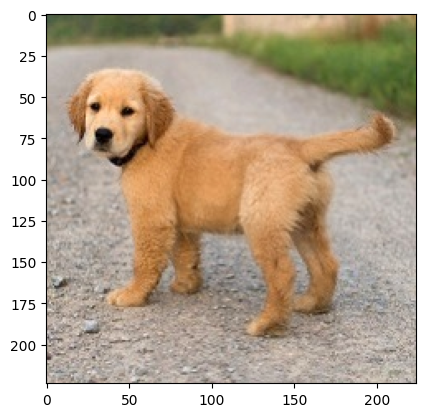

In [58]:

model.eval()
img = torchvision.io.read_image(str('/content/dog.jpg')).type(torch.float32)

transform = transforms.Compose([
    transforms.Resize((224, 224))
])

img = img/225

img = transform(img)

with torch.inference_mode():
    img = img.unsqueeze(dim=0)

    pred = model(img.to(device))

plt.imshow(img.squeeze().permute(1, 2, 0))

In [59]:
pred

[{'boxes': tensor([[  9.6225,  34.0006, 212.4209, 193.9326]], device='cuda:0'),
  'labels': tensor([18], device='cuda:0'),
  'scores': tensor([0.9994], device='cuda:0')}]

In [60]:
pred[0].keys()

dict_keys(['boxes', 'labels', 'scores'])

In [61]:
bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]

In [62]:
num = torch.argwhere(scores > 0.9).shape[0]

In [63]:
num

1

In [64]:
labels = labels.to('cpu')
bboxes = bboxes.to('cpu')

In [67]:
image = cv2.imread('/content/dog.jpg')
image = cv2.resize(image, (224, 224))
for i in range(num):
    x1, y1, x2, y2 = bboxes[i].numpy().astype("int")
    class_name = coco_names[labels.numpy()[i] - 2]
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
    image = cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)

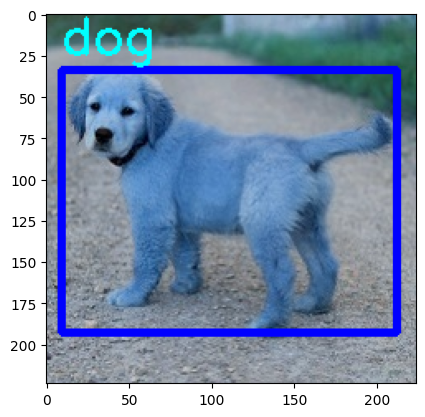

In [68]:
plt.imshow(image)

### Convert to OONX

In [69]:
dummy_input = torch.randn((1, 3, 224, 224))

In [71]:
model = model.to('cpu')

In [72]:
torch.onnx.export(model, dummy_input, 'faster_rcnn.onnx')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3912: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bo

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [73]:
!pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 10.6 MB/s eta 0:00:00


In [75]:
import onnxruntime
import numpy as np

model_onnx = onnxruntime.InferenceSession('faster_rcnn.onnx', providers=['CUDAExecutionProvider'])

# lay ten dau vao
input_name = model_onnx.get_inputs()[0].name
image = np.random.rand(1, 3, 224, 224).astype(np.float32)

ort_inputs = {input_name: image}
ort_outs = model_onnx.run(None, ort_inputs)

In [80]:
def preprocess(input_data):
    # covert to float32
    img_data = input_data.astype('float32')

    img_data = img_data / 255

    # add batch channel
    img_data = img_data.reshape(1, 3, 224, 224).astype('float32')

    return img_data

In [81]:
img = Image.open('/content/dog.jpg')
img = img.resize((224, 224))
img = np.array(img).transpose(2, 0, 1)
img = preprocess(img)
raw_result = model_onnx.run([], {input_name: img})

In [82]:
raw_result

[array([[ 10.061304,  34.23388 , 213.43245 , 194.0799  ]], dtype=float32),
 array([18], dtype=int64),
 array([0.99944025], dtype=float32)]

In [87]:
image = cv2.imread('/content/dog.jpg')
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
num = len(raw_result[0])

for i in range(num):
    if raw_result[2][i] > 0.9:
        x1, y1, x2, y2 = raw_result[0][i].astype('int')
        label = coco_names[raw_result[1][i] - 2]
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        image = cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 255), 2)


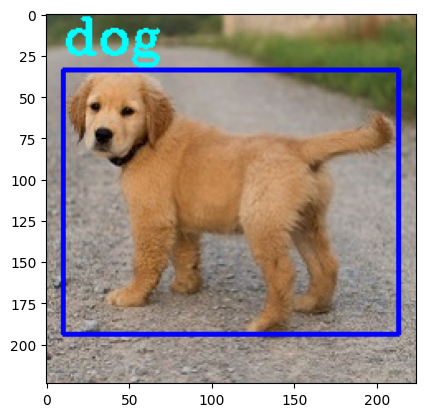

In [88]:
plt.imshow(image)